In [79]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
import pandas as pd
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

In [2]:
# # Load ImageNette
# from datasets import load_dataset

# dataset = load_dataset("frgfm/imagenette", '160px')
# dataset['train'] 

# puNCE Plots

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_55636/1786811525.py:50: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(
/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_55636/1786811525.py:50: UserWarning: 
The markers list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(
/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_55636/1786811525.py:64: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(


<Figure size 2400x1800 with 0 Axes>

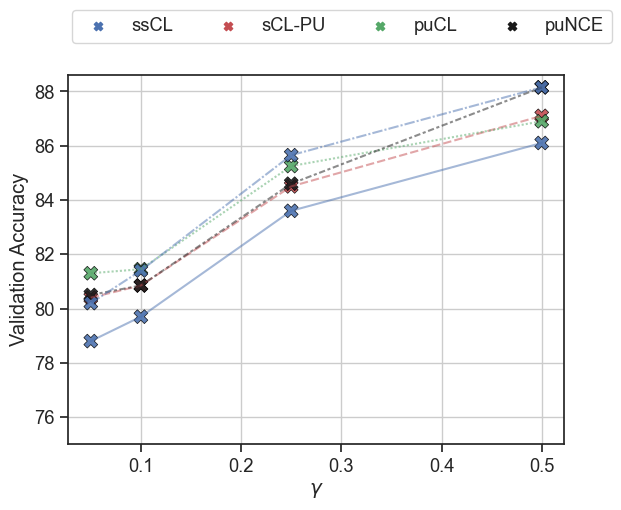

<Figure size 2400x1800 with 0 Axes>

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## CIFAR - Dog Cat

## nU = 10000 ===> nP_u = 5000, nN_u = 5000, \pi =0.5 , nP is varied as \gamma = nP / nU 
## num epochs = 200 
# -----------------------
gamma  = [i/10000 for i in[500, 1000, 2500, 5000]]
sscl   = [78.15, 78.05, 79.95, 80.25]
scl    = [63.70, 76.35, 83.65, 87.2]
pucl   = [79.0 , 79.25, 83.0,  86.10]
puNCE  = [81.3 , 81.45, 85.25, 86.90] # * optimal 

puNCE_pi_1 = [78.8, 79.7, 83.6, 86.1]
puNCE_pi_4 = [80.4, 80.85, 84.5, 87.1]
puNCE_pi_45 = [80.8, 80.7, 84.4, 87.65]
puNCE_pi_5  = [81.3, 81.45, 85.25, 86.90] # * optimal 
puNCE_pi_55 = [81.1, 80.65, 84.7, 87.9]
puNCE_pi_6 = [80.5, 80.85, 84.6, 88.15]
puNCE_pi_9 = [80.2, 81.4, 85.65, 88.15]

data = {
    'gamma': gamma, 
    'sscl': sscl, 
    'scl': scl, 
    'pucl': pucl, 
    'punce': puNCE
}
legend_labels = ['ssCL', 'sCL-PU', 'puCL', 'puNCE']
label_colors = [ 'b', 'r', 'g', 'k'] 
markers =['X', 'X', 'X', 'X']


data = {
    'gamma': gamma, 
    'puNCE_pi_1': puNCE_pi_1, 
    'puNCE_pi_4': puNCE_pi_4,
    'puNCE_pi_5': puNCE_pi_5,
    'puNCE_pi_6': puNCE_pi_6,
    'puNCE_pi_9': puNCE_pi_9,
}

df = pd.DataFrame(data)
df_melted = df.melt('gamma', var_name='loss', value_name='acc')
sns.set(style="ticks", font_scale=1.2)
ax = sns.scatterplot(
    data=df_melted, 
    x='gamma', 
    y='acc', 
    hue='loss', 
    style='loss', 
    
    s=100, 
    alpha=0.9, 
    edgecolor='black', 
    linewidth=0.5,
    palette=label_colors,
    markers=markers,
)
sns.lineplot(
    data=df_melted,
    x='gamma',
    y='acc', 
    hue='loss', 
    style='loss', 
    
    markers=False, 
    dashes=True, 
    alpha=0.5,
    palette=label_colors
)
handles, labels = ax.get_legend_handles_labels()
custom_legend = plt.legend(handles,  
                           legend_labels, 
                           title='', 
                           loc='upper left', 
                           ncol=4, bbox_to_anchor=(-0.01, 1.2))
plt.xlabel('$\gamma$')
plt.ylabel('Validation Accuracy')
plt.ylim(75)
plt.grid()
plt.figure(figsize=(8, 6), dpi=300)
# sns.despine()


In [83]:
import torch

def compute_nll_mtx(z, z_aug, temp):
    """
    compute Temp normalized - cross similarity (inner product) scores
    o/p [i,j] th entry:  [ exp(z_i, z_j) ]; [i, i] th entry = 0
    """
#     z = torch.nn.functional.normalize(z, dim=1)
#     z_aug = torch.nn.functional.normalize(z_aug, dim=1)
#     print('z = {}'.format(z))
#     print('z_aug = {}'.format(z_aug))

    # calculate similarities block-wise - the resulting vectors have shape (batch_size, batch_size)
    inner_pdt_00 = torch.einsum('nc,mc->nm', z, z) / temp
    inner_pdt_01 = torch.einsum('nc,mc->nm', z, z_aug) / temp
    inner_pdt_10 = torch.t(inner_pdt_01)
    inner_pdt_11 = torch.einsum('nc,mc->nm', z_aug, z_aug) / temp

    # concatenate blocks : o/p shape (2*batch_size, 2*batch_size)
    # [ Block 00 ] | [ Block 01 ]
    # [ Block 10 ] | [ Block 11 ]
    inner_pdt_0001 = torch.cat([inner_pdt_00, inner_pdt_01], dim=1)
    inner_pdt_1011 = torch.cat([inner_pdt_10, inner_pdt_11], dim=1)
    inner_pdt_mtx = torch.cat([inner_pdt_0001, inner_pdt_1011], dim=0)
    print('inner_pdt = {}'.format(inner_pdt_mtx))

    # for numerical stability
#     max_inner_pdt, _ = torch.max(inner_pdt_mtx, dim=1, keepdim=True)
#     inner_pdt_mtx = inner_pdt_mtx - max_inner_pdt.detach()
#     print('inner_pdt_scaled = {}'.format(inner_pdt_mtx))
    
    # mask out self-contrast
    diag_mask = torch.ones_like(inner_pdt_mtx, device=inner_pdt_mtx.device, dtype=torch.bool).fill_diagonal_(0)
    inner_pdt_mtx = inner_pdt_mtx * diag_mask
    print('diag removed inner pdt mtx ={}'.format(inner_pdt_mtx))
    
    # compute negative log-likelihoods
    nll_mtx = torch.exp(inner_pdt_mtx)
    print('exp inner pdt mtx = {}'.format(nll_mtx))
    # likehood 
    nll_mtx /= torch.sum(nll_mtx, dim=1, keepdim=True)
    print('Likelihood = {}'.format(nll_mtx))
    # Alternatively use softmax 
    sfx = torch.nn.Softmax(dim=1) 
    sfx_inner_pdt_mtx = sfx(inner_pdt_mtx)
    print('Softmax = {}'.format(sfx_inner_pdt_mtx))
    # Neg log-likehood
    nll_mtx[nll_mtx != 0] = -torch.log(nll_mtx[nll_mtx != 0])
    print('NLL = {}'.format(nll_mtx))
    
    bs, _ = z.shape
    cross_entropy = nn.CrossEntropyLoss(reduction='mean')
    labels = torch.arange(2 * bs, device=z.device, dtype=torch.long)
    loss = cross_entropy(inner_pdt_mtx, labels)
    
    print('CE Loss = {}'.format(loss))
    
    return nll_mtx

z = torch.Tensor([
    [3], 
    [5]
])
z_aug = torch.Tensor([
    [2], 
    [6]
])
temp = 1
torch.cat([z, z_aug], dim=0)
nll_mtx = compute_nll_mtx(z, z_aug, temp)

inner_pdt = tensor([[ 9., 15.,  6., 18.],
        [15., 25., 10., 30.],
        [ 6., 10.,  4., 12.],
        [18., 30., 12., 36.]])
diag removed inner pdt mtx =tensor([[ 0., 15.,  6., 18.],
        [15.,  0., 10., 30.],
        [ 6., 10.,  0., 12.],
        [18., 30., 12.,  0.]])
exp inner pdt mtx = tensor([[1.0000e+00, 3.2690e+06, 4.0343e+02, 6.5660e+07],
        [3.2690e+06, 1.0000e+00, 2.2026e+04, 1.0686e+13],
        [4.0343e+02, 2.2026e+04, 1.0000e+00, 1.6275e+05],
        [6.5660e+07, 1.0686e+13, 1.6275e+05, 1.0000e+00]])
Likelihood = tensor([[1.4508e-08, 4.7426e-02, 5.8528e-06, 9.5257e-01],
        [3.0590e-07, 9.3576e-14, 2.0612e-09, 1.0000e+00],
        [2.1785e-03, 1.1894e-01, 5.4000e-06, 8.7887e-01],
        [6.1442e-06, 9.9999e-01, 1.5230e-08, 9.3576e-14]])
Softmax = tensor([[1.4508e-08, 4.7426e-02, 5.8528e-06, 9.5257e-01],
        [3.0590e-07, 9.3576e-14, 2.0612e-09, 1.0000e+00],
        [2.1785e-03, 1.1894e-01, 5.4000e-06, 8.7887e-01],
        [6.1442e-06, 9.9999e-01, 1.

In [2]:
### Data Generation -- Gaussian Mixture 
def gen_data(
    k=2, 
    dim=2, 
    points_per_cluster=1000, 
    means=None, 
    covariances=None
):
    # Generate data from specified or random Gaussians
    if means is not None and covariances is None:
        raise ValueError("Covariances must be provided if means are provided.")
    if means is None:
        means = [np.random.rand(dim) for _ in range(k)]
    if covariances is None:
        covariances = [np.eye(dim) for _ in range(k)]
    x = []
    y = []
    for i in range(k):
        _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)
        x += list(_x)
        y += [i] * points_per_cluster
    x = np.array(x)
    y = np.array(y)
    return x, y

def create_positive_unlabeled(
    x, 
    y, 
    num_labeled, 
    means=None, 
    covariances=None, 
    setting='single_data'
):
    '''
    Creates positive examples (P) and unlabeled examples (0) based on given x and y.
    input:
        - x: Input data (total_examples, features)
        - y: True labels (total_examples,)
        - num_labeled: Number of positive examples (P)
    output:
        - labels: Generated labels (total_examples,)
    '''
    if setting == 'single_data':
        feat = x
        labels = np.zeros(len(y))               # Initialize labels with all 0 (unlabeled)
        positive_indices = np.where(y == 1)[0]  # Indices of positive examples in the true labels
        selected_indices = np.random.choice(positive_indices, size=num_labeled, replace=False)
        labels[selected_indices] = 1            # Assign label 1 to selected positive examples
    
    elif setting == 'case_control':
        x_, y_ = gen_data(
            k=2, 
            dim=2, 
            points_per_cluster=num_labeled, 
            means=means, 
            covariances=covariances
        )
        ix = np.where(y_ == 1)[0]
        x_P = x_[ix]
        feat = np.concatenate((x, x_P), axis=0)
        labels_P = np.ones(num_labeled)
        labels_U = np.zeros(len(y)) 
        labels = np.concatenate((labels_U, labels_P), axis=0)
        

    return feat, labels

In [3]:
# Classification Code
def train_linear_model(
    x, 
    y, 
    loss_fn='ce', 
    prior=0.5, 
    verbose=True, 
    lr=0.1,
    num_epochs=100
):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    model = nn.Linear(2, 2)
    if loss_fn == 'ce':
        criterion = nn.CrossEntropyLoss() 
    elif loss_fn in ['uPU', 'nnPU']:
        criterion = PULoss(prior= prior, loss_fn=loss_fn)
    else:
      raise NotImplementedError

    optimizer = optim.SGD(model.parameters(), lr=lr)
    num_epochs = num_epochs
    loss_values = []
    
    for epoch in range(num_epochs):
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
        loss_values.append(loss.item())
        if (epoch + 1) % 10 == 0 and verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        logits = model(X_test_tensor)
        predicted_labels = torch.argmax(logits, dim=1)
    accuracy = accuracy_score(y_test, predicted_labels.numpy())
    print(f"Accuracy: {accuracy:.4f}")
    
    return model, loss_values



class PULoss(nn.Module):
    def __init__(self, prior, loss_fn: str):
        super(PULoss, self).__init__()
        if not 0 < prior < 1:
            raise ValueError("The class prior should be in [0, 1]")
        self.prior, self.loss_fn = prior, loss_fn
        self.meta_loss = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        # logits: shape [Batch Size \times Num of Classes] - un-normalized raw linear combination (w_i * x_i + b)
        ix_positive = torch.where(targets == 1)[0]
        ix_unlabeled = torch.where(targets == 0)[0]

        pos_logits = torch.index_select(input=logits, dim=0, index=ix_positive)
        unlabeled_logits = torch.index_select(input=logits, dim=0, index=ix_unlabeled)

        targets_pos = torch.ones(len(ix_positive), dtype=targets.dtype)
        targets_pos_inverse = torch.zeros(len(ix_positive), dtype=targets.dtype)
        targets_unlabeled = torch.zeros(len(ix_unlabeled), dtype=targets.dtype)

        # compute empirical estimates
        # R_p+
        loss_positive = self.meta_loss(pos_logits.to(logits.device), targets_pos.to(targets.device)) \
            if ix_positive.nelement() != 0 else 0
        # R_u-
        loss_unlabeled = self.meta_loss(unlabeled_logits.to(logits.device), targets_unlabeled.to(targets.device)) \
            if ix_unlabeled.nelement() != 0 else 0
        # R_p-
        loss_pos_inv = self.meta_loss(pos_logits.to(logits.device), targets_pos_inverse.to(targets.device)) \
            if ix_positive.nelement() != 0 else 0
        # (1-pi) Rn- = R_u- - prior * R_p-
        loss_negative = loss_unlabeled - self.prior * loss_pos_inv

        if self.prior == 0:
            prior = ix_positive.nelement() / (ix_positive.nelement() + ix_unlabeled.nelement())
            # i.e. fully supervised equivalent to PN strategy
            return prior * loss_unlabeled + (1 - prior) * loss_positive
        elif self.loss_fn == 'nnPU':
            return - loss_negative if loss_negative < 0 else self.prior * loss_positive + loss_negative
        elif self.loss_fn == 'uPU':
            return self.prior * loss_positive + loss_negative
        else:
            ValueError('Unsupported Loss')


def puPL(x_PU, y_PU, num_clusters=2):
    p_ix = y_PU==1
    u_ix = y_PU==0
    x_P = x_PU[p_ix]
    x_U = x_PU[u_ix]
    
    ## Initialize Cluster Centers ##
    # Compute the mean of x_P as the first centroid: Note centroid_2 since we use P:1 N/U:0 
    centroid_2 = np.mean(x_P, axis=0)
    # Use K-means++ to choose the second center from x_U given the first center
    kmeans_pp = KMeans(n_clusters=1, init=np.array([centroid_2])) 
    kmeans_pp.fit(x_U)
    centroid_1 = kmeans_pp.cluster_centers_[0]
    centroids = np.array([centroid_1, centroid_2]) # Initialize the centroids with the computed values
    
    ## Perform K-means clustering with the initialized centroids
    kmeans = KMeans(n_clusters=num_clusters, init=centroids)
    kmeans.fit(np.concatenate((x_U, x_P), axis=0))

    labels = kmeans.labels_
    data = np.concatenate((x_U, x_P), axis=0)

    return labels, data

In [4]:
### Viz Data ---- Scatter Plot 
def plot_scatter(x, y, label_colors, model=None, lbl_map=None):
    # Plots a scatter plot of the generated data
    data = {'X': x[:, 0], 'Y': x[:, 1], 'Label': y}
    df = pd.DataFrame(data)
    if lbl_map is not None:
        df['Label'] = df['Label'].map(lbl_map)  # Map labels 0 to 'N' and 1 to 'P'
    sns.scatterplot(
        data=df, 
        x='X', 
        y='Y', 
        hue='Label', 
        palette=label_colors, 
        s=60, 
        alpha=0.8,
        edgecolor='k', 
        marker='o',
    )

def plot_decision_boundary(X, y, model,
                           boundary_color='k', 
                           boundary_linestyle='-'):
    # Generate a grid of points to plot the decision boundary
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float32)
    with torch.no_grad():
        logits = model(grid_points_tensor)
        predicted_labels = torch.argmax(logits, dim=1)
    # Reshape the predicted labels to match the grid shape
    decision_map = predicted_labels.reshape(xx.shape)
    CS = plt.contour(xx, yy, 
                         decision_map, 
                         alpha=0.5, 
                         colors=boundary_color, 
                         linestyles=boundary_linestyle
                    )
    # plt.clabel(CS, inline=1, fontsize=10)

In [ ]:
# supervised 
# Generate Data (PN) from Gaussians 
mean1 = np.array([0, 0])  # Mean of first cluster
cov1 = np.array([[0, 0.5], [0.5, 0]])  # Covariance matrix of first cluster

mean2 = np.array([3.5, 3.5])  # Mean of second cluster
cov2 = np.array([[1, 0.5], [0.5, 2]])  # Covariance matrix of second cluster
# mean2 = np.array([3.5, 3.5])  # Mean of second cluster
# cov2 = np.array([[0, 0.5], [1, 0]])  # Covariance matrix of second cluster

means = [mean1, mean2]
covariances = [cov1, cov2]

x, y = gen_data(
    k=2, 
    dim=2, 
    points_per_cluster=1500, 
    means=means, 
    covariances=covariances
)

model, loss = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False) 

plt.figure(figsize=(8,6))
label_colors = [
    '#ff7f0e', 
    '#1f77b4'
] 
lbl_map = {
    0: r'$y^\ast = 0$', 
    1: r'$y^\ast = 1$'
}
plot_scatter(x, y, label_colors, lbl_map=lbl_map)
plot_decision_boundary(x, y, model, boundary_color='k')

# Adjust these coordinates as needed
plt.annotate(
    r'$CE^\ast$', 
    xy=(-1, 2.8), 
    fontsize=12, 
    fontweight='bold', 
    color='k'
)

plt.xlabel('X0', fontweight='bold')
plt.ylabel('X1', fontweight='bold')
plt.legend(loc='upper left', ncol=3, fontsize=20, prop={'weight': 'bold', 'size':'large'})
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/var/folders/8c/br5wk04x7616nc7rcdx8fxj80000gq/T/ipykernel_4626/3128024426.py:19: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  _x = np.random.multivariate_normal(means[i], covariances[i], points_per_cluster)


Accuracy: 0.9900


Accuracy: 1.0000
Accuracy: 0.8080
Epoch [10/100], Loss: 0.7923
Epoch [20/100], Loss: 0.6499
Epoch [30/100], Loss: 0.5729
Epoch [40/100], Loss: 0.5276
Epoch [50/100], Loss: 0.4983
Epoch [60/100], Loss: 0.4775
Epoch [70/100], Loss: 0.4618
Epoch [80/100], Loss: 0.4493
Epoch [90/100], Loss: 0.4389
Epoch [100/100], Loss: 0.4299
Accuracy: 0.7120
Epoch [10/100], Loss: 0.5580
Epoch [20/100], Loss: 0.4733
Epoch [30/100], Loss: 0.4209
Epoch [40/100], Loss: 0.3864
Epoch [50/100], Loss: 0.3624
Epoch [60/100], Loss: 0.3449
Epoch [70/100], Loss: 0.3316
Epoch [80/100], Loss: 0.3211
Epoch [90/100], Loss: 0.3126
Epoch [100/100], Loss: 0.3056
Accuracy: 0.6280
Epoch [10/100], Loss: 0.3464
Epoch [20/100], Loss: 0.2674
Epoch [30/100], Loss: 0.2173
Epoch [40/100], Loss: 0.1832
Epoch [50/100], Loss: 0.1587
Epoch [60/100], Loss: 0.1403
Epoch [70/100], Loss: 0.1260
Epoch [80/100], Loss: 0.1146


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


Epoch [90/100], Loss: 0.1053
Epoch [100/100], Loss: 0.0975
Accuracy: 0.9920


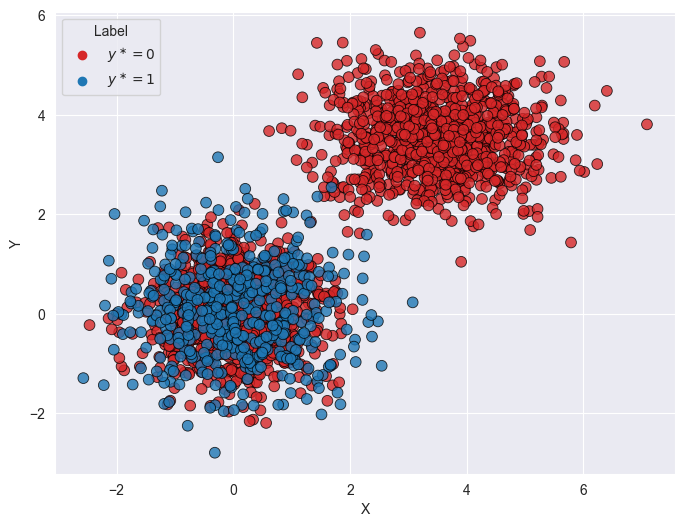

In [6]:
nP_L = 500
prior_true = 0.5

x_PU, y_PU = create_positive_unlabeled(x, y, num_labeled=nP_L, setting='case_control')

model_opt, loss_opt = train_linear_model(x, y, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)
model_CE, loss_CE = train_linear_model(x_PU, y_PU, loss_fn='ce', lr=0.1, num_epochs=1000, verbose=False)


# uPU
model_pu_nnPU, loss = train_linear_model(x_PU, y_PU, loss_fn='uPU', lr=0.005, prior=prior_true)
# nnPU
model_pu_nnPU, loss = train_linear_model(x_PU, y_PU, loss_fn='nnPU', lr=0.005, prior=prior_true)

# puPL + CE
y_hat_PU, x_hat_PU = puPL(x_PU, y_PU, num_clusters=2)                           # get pseudo-labels
model_pu_puPL, loss = train_linear_model(x_PU, y_hat_PU, loss_fn='ce', lr=0.1)  # train with puPL+CE


plt.figure(figsize=(8,6))
label_colors = [
    '#d62728', 
    '#1f77b4'
] 
lbl_map = {
    0: r'$y^\ast = 0$', 
    1: r'$y^\ast = 1$'
}
plot_scatter(x_PU, y_PU, label_colors, lbl_map=lbl_map)
# plot_decision_boundary(x_PU, y_PU, model_opt, boundary_color='k')
# plot_decision_boundary(x, y, model_opt, boundary_color='k')
# plot_decision_boundary(x, y, model_opt, boundary_color='k')
# plot_decision_boundary(x, y, model_opt, boundary_color='k')
plt.show()

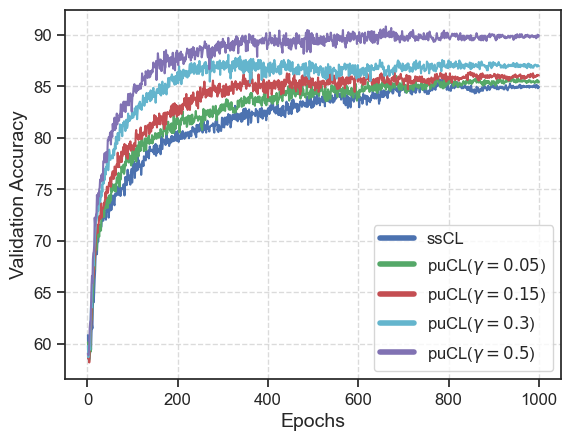

<Figure size 2400x1800 with 0 Axes>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

# List of CSV file paths
file_paths = [
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-ssCL-unsup_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=500_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=1500_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=3000_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=5000_seed=0.csv',
]

# Create a list to store DataFrames
dfs = []

# Loop through the file paths, read the CSV data, and store it in the list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['Value'] = pd.to_numeric(df['Value'])
    dfs.append(df)

# Create the plots for each DataFrame
# line_styles = ['-', '--', '-.', ':', '-']
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['o', 's', 'v', '^', 'D']

for i, df in enumerate(dfs):
    plt.plot(range(1, 1001), df['Value'], 
             label=f'Line {i+1}', 
             # linestyle=line_styles[i], 
             color=colors[i], 
             #marker=markers[i]
            )

# Customize the plot for a paper
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
legend = plt.legend([r'ssCL',
            r'puCL($\gamma=0.05$)', 
            r'puCL($\gamma=0.15$)',
            r'puCL($\gamma=0.3$)',
            r'puCL($\gamma=0.5$)'], fontsize=12)
for line in legend.get_lines():
    line.set_linewidth(4)  # Adjust the linewidth as needed
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Increase figure size for better readability
plt.figure(figsize=(8, 6), dpi=300)

# Save the plot as a high-resolution image (e.g., PNG) for your paper
# plt.savefig('paper_plot.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()

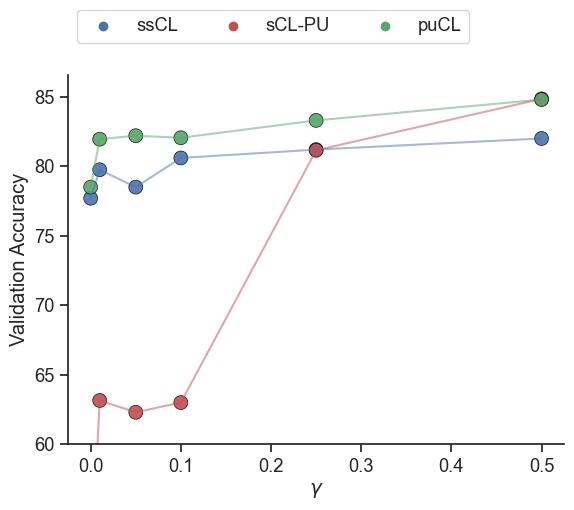

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
label_colors = [ 'b', 'r', 'g'] 
sns.set(style="ticks", font_scale=1.2)
def fig1(df, x):
    ax = sns.scatterplot(x=x, y='acc', 
                         hue='loss', 
                         style='loss', 
                         data=df_melted, 
                         s=100, 
                         alpha=0.9, 
                         edgecolor='black', 
                         linewidth=0.5,
                        palette=label_colors,
                        markers=['o', 'o', 'o'])
    sns.lineplot(x=x, 
                 y='acc', 
                 hue='loss', 
                 style='loss', 
                 markers=False, 
                 dashes=False, 
                 data=df_melted, 
                 alpha=0.5,
                palette=label_colors,)
    
    handles, labels = ax.get_legend_handles_labels()
    legend_labels = ['ssCL', 'sCL-PU', 'puCL']
    custom_legend = plt.legend(handles,  
                               legend_labels, 
                               title='', 
                               loc='upper left', 
                               ncol=4, bbox_to_anchor=(0, 1.2))
    plt.xlabel('$\gamma$')
    plt.ylabel('Validation Accuracy')

    sns.despine()
    plt.ylim(60,)

## Fixed: \pi = 0.5 
## nU = 10000 ===> nP_u = 5000, nN_u = 5000
gamma  = [i/10000 for i in[ 0, 100, 500, 1000, 2500, 5000]]
sscl   = [77.70, 79.75, 78.50, 80.60, 81.20, 82.00]
scl    = [   50, 63.15, 62.30, 63.00, 81.15, 84.85]
pucl   = [78.50, 81.95, 82.20, 82.05, 83.30, 84.80]
nnPU   = [50, 56.75, 57.05, 67.1, 79.3, 81.63]

data_10k = {'gamma': gamma, 'sscl': sscl, 'scl': scl, 'pucl': pucl}
df_10k = pd.DataFrame(data_10k)
df_melted = df_10k.melt('gamma', var_name='loss', value_name='acc')
fig1(df_melted, x='gamma')

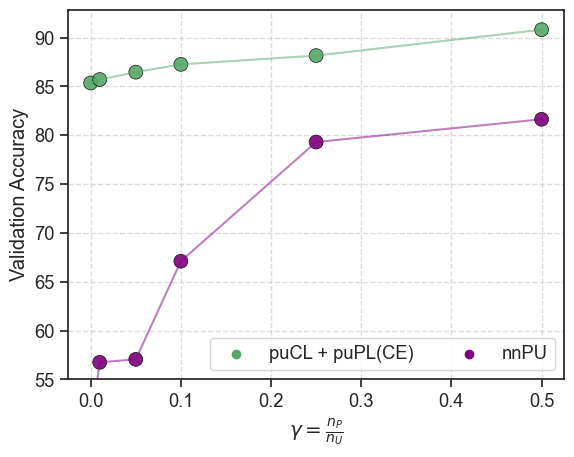

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
label_colors = [ 'g','purple'] 
sns.set(style="ticks", font_scale=1.2)
def fig1(df, x):
    ax = sns.scatterplot(x=x, y='acc', 
                         hue='loss', 
                         style='loss', 
                         data=df_melted, 
                         s=100, 
                         alpha=0.9, 
                         edgecolor='black', 
                         linewidth=0.5,
                        palette=label_colors,
                        markers=['o', 'o'])
    sns.lineplot(x=x, 
                 y='acc', 
                 hue='loss', 
                 style='loss', 
                 markers=False, 
                 dashes=False, 
                 data=df_melted, 
                 alpha=0.5,
                palette=label_colors,)
    
    handles, labels = ax.get_legend_handles_labels()
    legend_labels = ['puCL + puPL(CE)', 'nnPU']
    custom_legend = plt.legend(handles,  
                               legend_labels, 
                               title='', 
                               loc='lower right', 
                               ncol=2)
    plt.xlabel(r'$\gamma = \frac{n_P}{n_U}$')
    plt.ylabel('Validation Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    # sns.despine()
    plt.ylim(55,)

## Fixed: \pi = 0.5 
## nU = 10000 ===> nP_u = 5000, nN_u = 5000
gamma  = [i/10000 for i in[ 0, 100, 500, 1000, 2500, 5000]]

pucl   = [85.35, 85.7, 86.45, 87.25, 88.15, 90.8]

nnPU   = [50, 56.75, 57.05, 67.1, 79.3, 81.63]

data_10k = {'gamma': gamma, 'pucl': pucl, 'nnpu': nnPU, }
df_10k = pd.DataFrame(data_10k)
df_melted = df_10k.melt('gamma', var_name='loss', value_name='acc')
fig1(df_melted, x='gamma')

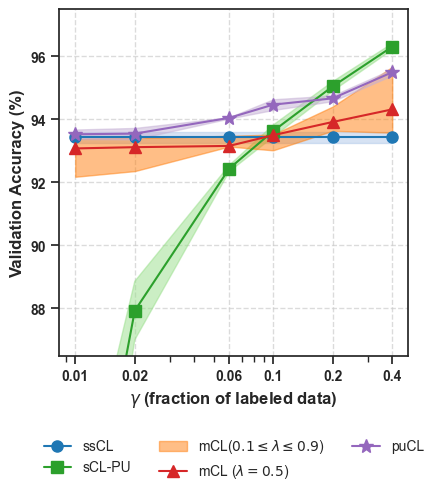

<Figure size 2400x1800 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.2)
import numpy as np

x = [1, 2, 6, 10, 20, 40]
x_labels = ['0.01', '0.02', '0.06', '0.1', '0.2', '0.4']

y_simclr = np.array([93.43]*6)
y_simclr_err = np.array([0.18]*6)

y_suNCEt = np.array([93.53, 93.55, 94.05, 94.47, 94.67, 95.50])
y_suNCEt_err = np.array([0.15, 0.18, 0.02, 0.17, 0.09, 0.10])

y_scl = np.array([77.90, 87.93, 92.44, 93.63, 95.05, 96.31])
y_scl_err = np.array([3.02, 0.93, 0.10, 0.19, 0.15, 0.1])

y_mcl_max = np.array([93.39, 93.41, 93.48, 93.52, 94.41, 95.67])
y_mcl_min = np.array([92.18, 92.36, 93.14, 93.02, 93.64, 93.58])
y_mcl_half = np.array([93.08, 93.12, 93.16, 93.50, 93.92, 94.32])

# plt.rcParams['axes.facecolor'] = '#f5f5f5'
# plt.figure(figsize=(10, 6))
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

plt.plot(x, y_simclr, linestyle='-', label='ssCL', color='#1f77b4', marker='o', markersize=8)
plt.fill_between(x, y_simclr + y_simclr_err, y_simclr - y_simclr_err, animated=True, color='#aec7e8', alpha=0.5)

plt.plot(x, y_scl, linestyle='-', label='sCL-PU', color='#2ca02c', marker='s', markersize=8)
plt.fill_between(x, y_scl + y_scl_err, y_scl - y_scl_err, animated=True, color='#98df8a', alpha=0.5)

plt.fill_between(x, y_mcl_max, y_mcl_min, label=r'mCL($0.1 \leq \lambda \leq 0.9$)', color='#ff7f0e', joinstyle='bevel', alpha=0.5)
plt.plot(x, y_mcl_half, linestyle='-', color='#d62728', label=r'mCL ($\lambda=0.5$)', marker='^', markersize=8)

plt.plot(x, y_suNCEt, linestyle='-', label='puCL', color='#9467bd', marker='*', markersize=10)
plt.fill_between(x, y_suNCEt + y_suNCEt_err, y_suNCEt - y_suNCEt_err, animated=True, color='#c5b0d5', alpha=0.5)

plt.ylim(86.5, 97.5)
plt.xscale('log')

plt.xlabel('$\gamma$ (fraction of labeled data)', fontweight='bold', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
plt.xticks(x, x_labels, rotation=0, fontweight='bold', fontsize=10)
plt.yticks(fontweight='bold', fontsize=10)
# handles, labels = plt.gca().get_legend_handles_labels()

# plt.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.title("Comparison of Test Accuracy for Different Learning Methods", fontweight='bold', fontsize=14, pad=20)
plt.figure(figsize=(8, 6), dpi=300)
plt.show()

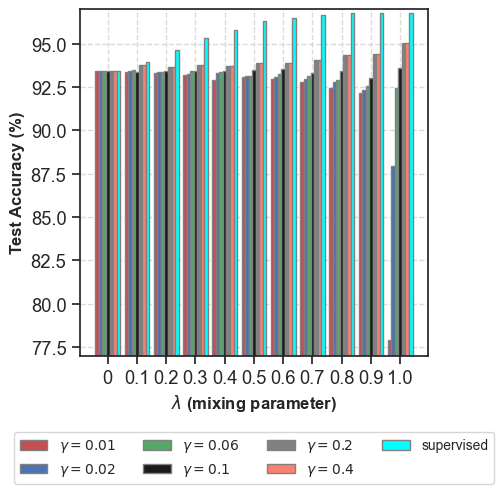

<Figure size 2400x1800 with 0 Axes>

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.2)
import numpy as np

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
x_labels      = [  '0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

y_mcl_500     = [93.43, 93.39, 93.30, 93.23, 92.93, 93.08, 92.95, 92.81, 92.43, 92.18, 77.90]
y_mcl_500_err = [ 0.13,  0.09,  0.07,  0.04,  0.09,  0.16,  0.16,  0.04,  0.22,  0.29,  3.02]

y_mcl_1k      = [93.43, 93.41, 93.39, 93.28, 93.29, 93.12, 93.10, 92.95, 92.77, 92.36, 87.93]
y_mcl_1k_err  = [ 0.13,  0.01,  0.09,  0.28,  0.06,  0.12,  0.12,  0.09,  0.24,  0.30,  0.93]

y_mcl_3k      = [93.43, 93.48, 93.38, 93.44, 93.35, 93.16, 93.28, 93.14, 92.93, 92.55, 92.44]
y_mcl_3k_err  = [ 0.13,  0.09,  0.10,  0.07,  0.10,  0.07,  0.09,  0.15,  0.11,  0.22,  0.10]

y_mcl_5k      = [93.43, 93.40, 93.44, 93.41, 93.44, 93.50, 93.52, 93.34, 93.46, 93.02, 93.63]
y_mcl_5k_err  = [0.13, 0.17, 0.10, 0.07, 0.09, 0.12, 0.10, 0.18, 0.19, 0.15, 0.19]

y_mcl_10k      = [93.43, 93.77, 93.64, 93.80, 93.71, 93.92, 93.88, 94.04, 94.34, 94.41, 95.05]
y_mcl_10k_err  = [0.13, 0.19, 0.19, 0.18, 0.21, 0.06, 0.14, 0.13, 0.07, 0.03, 0.15]

y_mcl_20k      = [93.43, 93.59, 93.58, 93.71, 94.22, 94.32, 94.82, 95.09, 95.53, 95.67, 96.31]
y_mcl_20k_err  = [0.13, 0.08, 0.05, 0.10, 0.38, 0.01, 0.10, 0.07, 0.03, 0.08, 0.08]

y_mcl_sup      = [93.43, 93.95, 94.66, 95.35, 95.80, 96.33, 96.48, 96.67, 96.80, 96.76, 96.79]
y_mcl_sup_err  = [0.13, 0.06, 0.09, 0.10, 0.09, 0.08, 0.04, 0.08, 0.08, 0.05, 0.10]

barWidth= 0.12
br_center = np.arange(len(y_mcl_500))
br1 = [x - 3*barWidth for x in br_center]
plt.bar(br1, y_mcl_500, color ='r', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.01$')

br2 = [x - 2*barWidth for x in br_center]
plt.bar(br2, y_mcl_1k, color ='b', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.02$')

br3 = [x - barWidth for x in br_center]
plt.bar(br3, y_mcl_3k, color ='g', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.06$')

br4 = br_center
plt.bar(br4, y_mcl_5k, color ='k', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.1$')

br5 = [x + barWidth for x in br4]
plt.bar(br5, y_mcl_10k, color ='grey', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.2$')

br6 = [x + barWidth for x in br5]
plt.bar(br6, y_mcl_10k, color ='salmon', width = barWidth, edgecolor ='grey', label =r'$\gamma = 0.4$')

br7 = [x + barWidth for x in br6]
plt.bar(br7, y_mcl_sup, color ='cyan', width = barWidth, edgecolor ='grey', label ='supervised')

params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

plt.ylim(77, 97)
plt.xlabel(r'$\lambda$ (mixing parameter)', fontweight='bold', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontweight='bold', fontsize=12)
plt.xticks(x, x_labels, rotation=0)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=4)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.title("Comparison of Test Accuracy for Different Learning Methods", fontweight='bold', fontsize=14, pad=20)
plt.figure(figsize=(8, 6), dpi=300)
plt.show()
# plt.grid(color='grey', linestyle='-', linewidth=2, axis='x')

# Rebuttal Figures 

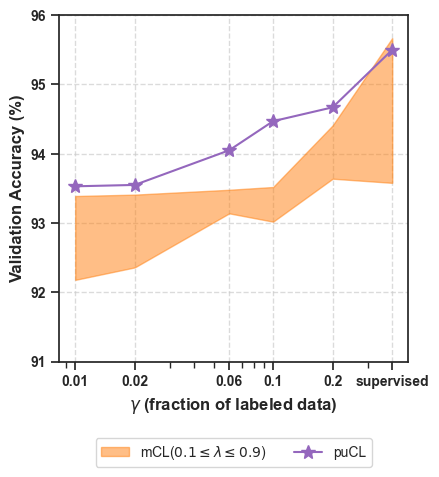

<Figure size 2400x1800 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", font_scale=1.2)
import numpy as np

x = [1, 2, 6, 10, 20, 40]
x_labels = ['0.01', '0.02', '0.06', '0.1', '0.2', 'supervised']

y_suNCEt = np.array([93.53, 93.55, 94.05, 94.47, 94.67, 95.50])
y_mcl_max = np.array([93.39, 93.41, 93.48, 93.52, 94.41, 95.67])
y_mcl_min = np.array([92.18, 92.36, 93.14, 93.02, 93.64, 93.58])

# y_dcl_max =

# plt.rcParams['axes.facecolor'] = '#f5f5f5'
# plt.figure(figsize=(10, 6))
params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)


plt.fill_between(x, y_mcl_max, y_mcl_min, label=r'mCL($0.1 \leq \lambda \leq 0.9$)', color='#ff7f0e', joinstyle='bevel', alpha=0.5)
# plt.plot(x, y_mcl_half, linestyle='-', color='#d62728', label=r'mCL ($\lambda=0.5$)', marker='^', markersize=8)

plt.plot(x, y_suNCEt, linestyle='-', label='puCL', color='#9467bd', marker='*', markersize=10)
# plt.plot(x, y_scl, linestyle='-', label='sCL-PU', color='#2ca02c', marker='s', markersize=8)

plt.ylim(91, 96)
plt.xscale('log')

plt.xlabel('$\gamma$ (fraction of labeled data)', fontweight='bold', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontweight='bold', fontsize=12)
plt.xticks(x, x_labels, rotation=0, fontweight='bold', fontsize=10)
plt.yticks(fontweight='bold', fontsize=10)
# handles, labels = plt.gca().get_legend_handles_labels()

# plt.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.7)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.title("Comparison of Test Accuracy for Different Learning Methods", fontweight='bold', fontsize=14, pad=20)
plt.figure(figsize=(8, 6), dpi=300)
plt.show()

## DCL - sensitivity to hyper-param

Text(0, 0.5, 'Validation Accuracy')

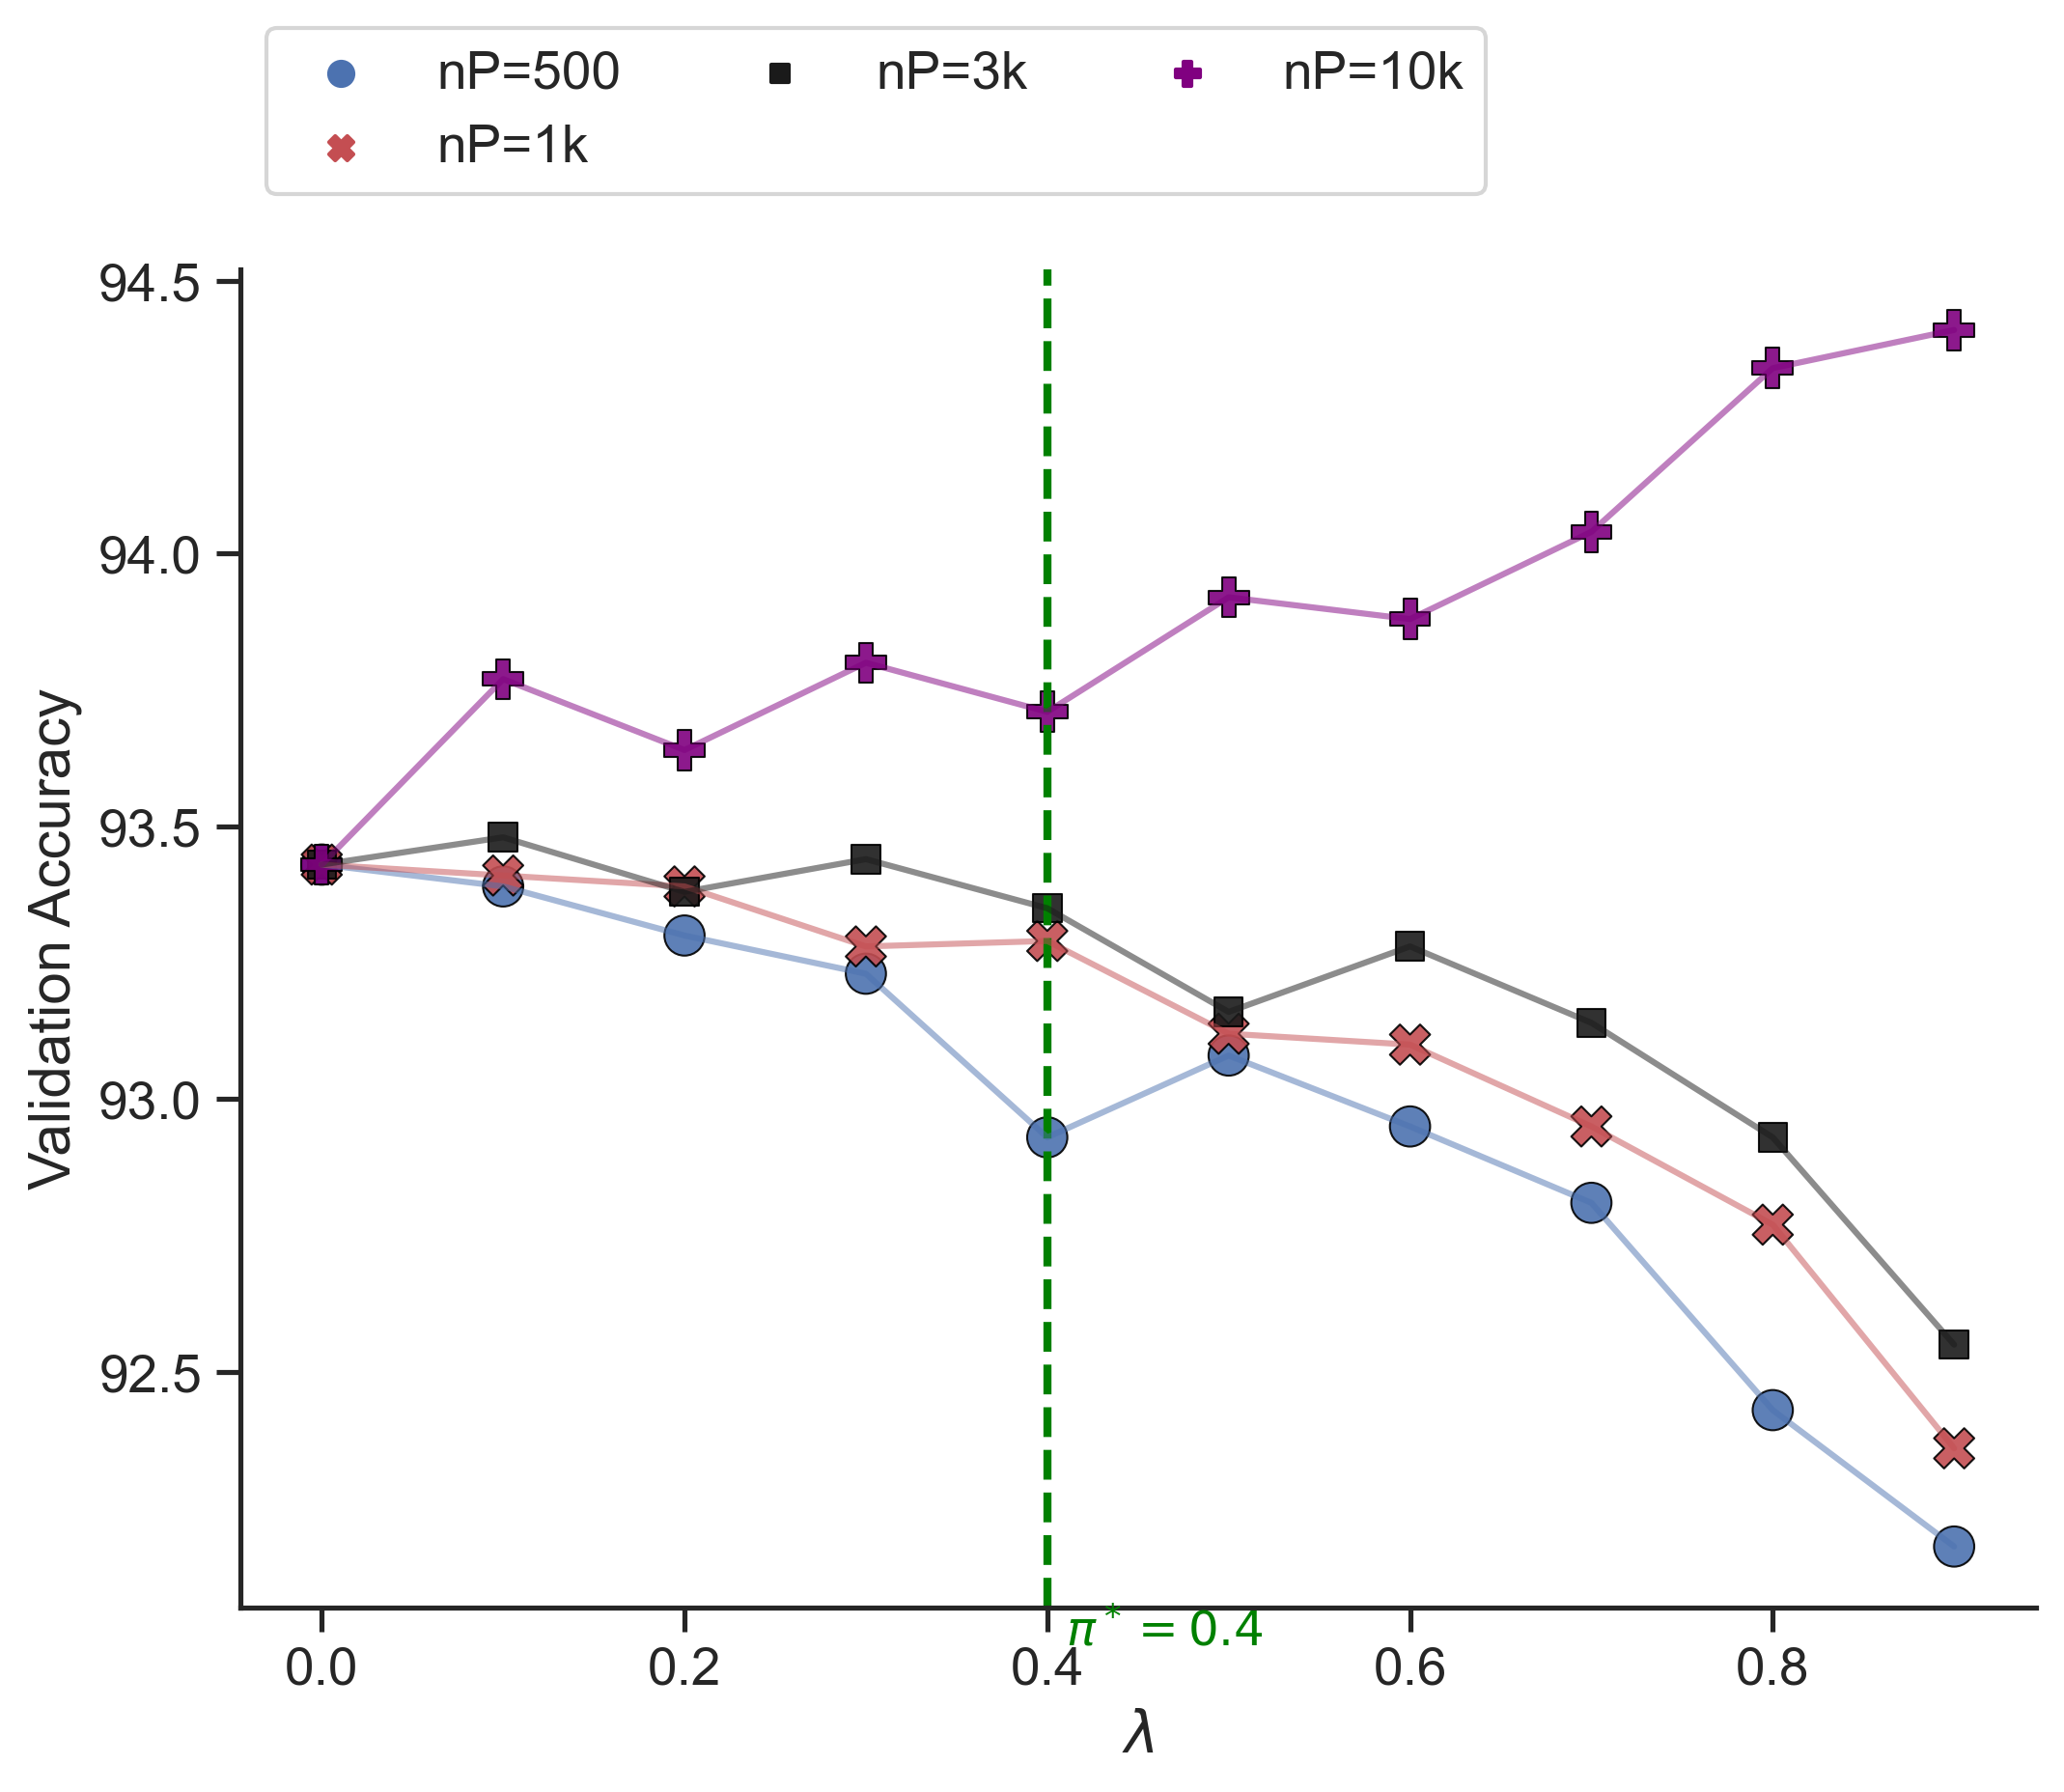

In [34]:
# ------------
## CIFAR-10.1 
# ------------ 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def fig1(df, x):
    ax = sns.scatterplot(x=x, 
                         y='acc', 
                         hue='loss', 
                         style='loss', 
                         data=df, 
                         s=100, 
                         alpha=0.9, 
                         edgecolor='black', 
                         linewidth=0.5,
                         palette=label_colors)
    
    sns.lineplot(x=x, 
                 y='acc', 
                 hue='loss', 
                 style='loss', 
                 markers=False, 
                 dashes=False, 
                 data=df, 
                 alpha=0.5,
                 palette=label_colors)

    handles, labels = ax.get_legend_handles_labels()
    custom_legend = plt.legend(handles,  
                               legend_labels, 
                               title='', 
                               loc='upper left', 
                               ncol=3, 
                               bbox_to_anchor=(0, 1.2))

    sns.despine()
    return ax 


### Across lambda
### ------------------  
# pi = [0.1, 0.3, 0.4, 0.5, 0.7, 0.9]
# label_colors = [ 'b', 'r', 'k', 'purple'] 
# legend_labels = ['nP=500', 'nP=1k', 'nP=3k', 'nP=10k']
# sns.set(style="ticks", font_scale=1.2)

# DCL_10k = [93.45, 93.47, 93.38, 92.84, 92.45, 90.17] 
# DCL_3k = [92.93, 93.18, 93.09, 92.69, 92.05, 89.8]
# DCL_1k = [92.77, 93.16, 92.51, 92.36, 92.36, 88.96]
# DCL_500 = [92.73, 92.85, 92.88, 92.92, 92.05, 89.66]

# data = {'pi': pi, 'nP=500': DCL_500, 'nP=1k': DCL_1k, 'nP=3k': DCL_3k, 'nP=10k': DCL_10k}

# df = pd.DataFrame(data)
# df_melted = df.melt('pi', var_name='loss', value_name='acc')
# plt.figure(figsize=(8, 6), dpi=300)
# fig1(df_melted, x='pi')

# plt.xlabel('$\lambda$')
# plt.ylabel('Validation Accuracy')

### Repeat for MCL 
label_colors = [ 'b', 'r', 'k', 'purple'] 
legend_labels = ['nP=500', 'nP=1k', 'nP=3k', 'nP=10k']
sns.set(style="ticks", font_scale=1.2)
pi = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


MCL_500     = [93.43, 93.39, 93.30, 93.23, 92.93, 93.08, 92.95, 92.81, 92.43, 92.18]
y_mcl_500_err = [ 0.13,  0.09,  0.07,  0.04,  0.09,  0.16,  0.16,  0.04,  0.22,  0.29,  3.02]

MCL_1k      = [93.43, 93.41, 93.39, 93.28, 93.29, 93.12, 93.10, 92.95, 92.77, 92.36]
y_mcl_1k_err  = [ 0.13,  0.01,  0.09,  0.28,  0.06,  0.12,  0.12,  0.09,  0.24,  0.30,  0.93]

MCL_3k      = [93.43, 93.48, 93.38, 93.44, 93.35, 93.16, 93.28, 93.14, 92.93, 92.55]
y_mcl_3k_err  = [ 0.13,  0.09,  0.10,  0.07,  0.10,  0.07,  0.09,  0.15,  0.11,  0.22,  0.10]

MCL_10k      = [93.43, 93.77, 93.64, 93.80, 93.71, 93.92, 93.88, 94.04, 94.34, 94.41]
y_mcl_10k_err  = [0.13, 0.19, 0.19, 0.18, 0.21, 0.06, 0.14, 0.13, 0.07, 0.03, 0.15]


data = {'pi': pi, 'nP=500': MCL_500, 'nP=1k': MCL_1k, 'nP=3k': MCL_3k, 'nP=10k': MCL_10k}
df = pd.DataFrame(data)
df_melted = df.melt('pi', var_name='loss', value_name='acc')
plt.figure(figsize=(8, 6), dpi=300)
fig1(df_melted, x='pi')

plt.xlabel('$\lambda$')
plt.ylabel('Validation Accuracy')

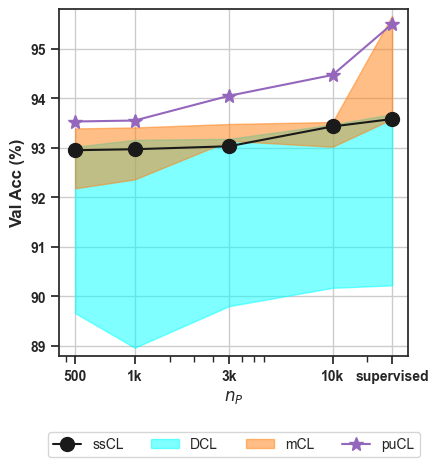

<Figure size 2400x1800 with 0 Axes>

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# DCL Sensitivity - Variation
sns.set(style="ticks", font_scale=1.2)

DCL_10k = [93.45, 93.47, 93.38, 92.84, 92.45, 90.17] 
DCL_3k  = [92.93, 93.18, 93.09, 92.69, 92.05, 89.80]
DCL_1k  = [92.77, 93.16, 92.51, 92.36, 92.36, 88.96]
DCL_500 = [92.73, 92.85, 92.88, 92.92, 92.05, 89.66]

# x axis is nP 
DCL_max = [93.02, 93.16, 93.18, 93.47, 93.68]
DCL_min = [89.66, 88.96, 89.80, 90.17, 90.22]
puCL    = [93.53, 93.55, 94.05, 94.47, 95.50]
ssCL    = [92.95, 92.97, 93.03, 93.43, 93.58]
y_mcl_max = [93.39, 93.41, 93.48, 93.52, 95.67]
y_mcl_min = [92.18, 92.36, 93.14, 93.02, 93.58]

params = {
   'axes.labelsize': 8,
   'font.size': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

x = [1, 2, 6, 20, 40]
x_labels = ['500', '1k', '3k', '10k' ,'supervised']

plt.plot(x, ssCL, linestyle='-', label='ssCL', color='k', marker='o', markersize=10)
plt.fill_between(x, DCL_max, DCL_min, label=r'DCL', color='cyan', joinstyle='bevel', alpha=0.5)
plt.fill_between(x, y_mcl_max, y_mcl_min, label=r'mCL', color='#ff7f0e', joinstyle='bevel', alpha=0.5)
plt.plot(x, puCL, linestyle='-', label='puCL', color='#9467bd', marker='*', markersize=10)

plt.xlabel('$n_P$', fontweight='bold', fontsize=12)
plt.ylabel('Val Acc (%)', fontweight='bold', fontsize=12)

plt.ylim(88.8, 95.8)
plt.xscale('log')
plt.xticks(x, x_labels, rotation=0, fontweight='bold', fontsize=10)
plt.yticks(fontweight='bold', fontsize=10)
plt.grid()

# plt.legend(ncol=4, loc='lower right')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=4)
plt.figure(figsize=(8, 6), dpi=300)
plt.show()

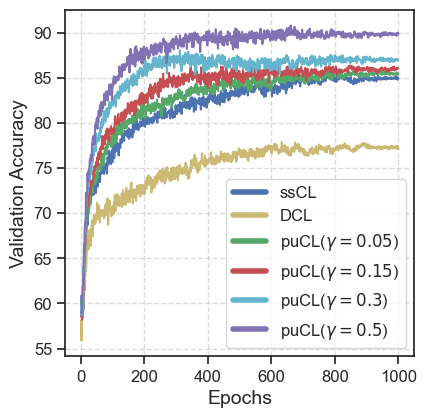

<Figure size 2400x1800 with 0 Axes>

In [40]:
# Convergence 
# -------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

# List of CSV file paths
file_paths = [
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-ssCL-unsup_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-DCL-unsup_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=500_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=1500_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=3000_seed=0.csv',
    '/Users/aa56927-admin/Desktop/Work/ICLR_plots/tf_logging_cifar10.dog_cat_pt-puCL-nP=5000_seed=0.csv',
]

# Create a list to store DataFrames
dfs = []

# Loop through the file paths, read the CSV data, and store it in the list
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['Value'] = pd.to_numeric(df['Value'])
    dfs.append(df)

# Create the plots for each DataFrame
# line_styles = ['-', '--', '-.', ':', '-']
colors = ['b', 'y', 'g', 'r', 'c', 'm']
markers = ['o', 'p', 's', 'v', '^', 'D']

for i, df in enumerate(dfs):
    plt.plot(range(1, 1001), df['Value'], 
             label=f'Line {i+1}', 
             # linestyle=line_styles[i], 
             color=colors[i], 
             #marker=markers[i]
            )

# Customize the plot for a paper
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
legend = plt.legend([r'ssCL',
            r'DCL',
            r'puCL($\gamma=0.05$)', 
            r'puCL($\gamma=0.15$)',
            r'puCL($\gamma=0.3$)',
            r'puCL($\gamma=0.5$)'], fontsize=12)
for line in legend.get_lines():
    line.set_linewidth(4)  # Adjust the linewidth as needed
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Increase figure size for better readability
plt.figure(figsize=(8, 6), dpi=300)

# Save the plot as a high-resolution image (e.g., PNG) for your paper
# plt.savefig('paper_plot.png', bbox_inches='tight')

# Show the plot (optional)
plt.show()